In [11]:
from transformers import pipeline
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt


In [12]:
articles_df = pd.read_csv("cleaned_articles_2016_2024.csv")

In [ ]:
#This code was partially generated with the help of ChatGPT-4o-mini

In [13]:
#we load a sentiment analysis pipeline using a BERT model (distilBERT)
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

#we apply sentiment analysis to each article (but it is truncated text to 512 tokens cause that was the maximum it could take)
articles_df['hf_sentiment'] = articles_df['cleaned_text'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label']) 


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [14]:
#weoad the tokenizer to count how many tokens each article has
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

articles_df['token_count'] = articles_df['cleaned_text'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

#need to check how many articles exceed 512 tokens, to see which ones are not taken into account in the analysis
over_512 = articles_df[articles_df['token_count'] > 512]
print(f"Number of articles with more than 512 tokens: {len(over_512)}")
print(f"Total number of articles: {len(articles_df)}")


Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors


Number of articles with more than 512 tokens: 1907
Total number of articles: 2532


In [15]:
#let's just see if the hugging face sentiment analysis worked :
articles_df['hf_sentiment']

0       NEGATIVE
1       POSITIVE
2       NEGATIVE
3       POSITIVE
4       NEGATIVE
          ...   
2527    NEGATIVE
2528    POSITIVE
2529    NEGATIVE
2530    NEGATIVE
2531    NEGATIVE
Name: hf_sentiment, Length: 2532, dtype: object

In [16]:
articles_df['article_date_created'] = pd.to_datetime(articles_df['article_date_created'], errors='coerce')
articles_df['year'] = articles_df['article_date_created'].dt.year
articles_df['month'] = articles_df['article_date_created'].dt.to_period('M') 

In [17]:
#then we define the sentiment score (transform the hugging face sentiment to scores (-1,1 or 0)
articles_df['sentiment_score'] = articles_df['hf_sentiment'].map({
    'POSITIVE': 1,
    'NEGATIVE': -1,
    'NEUTRAL': 0  
})

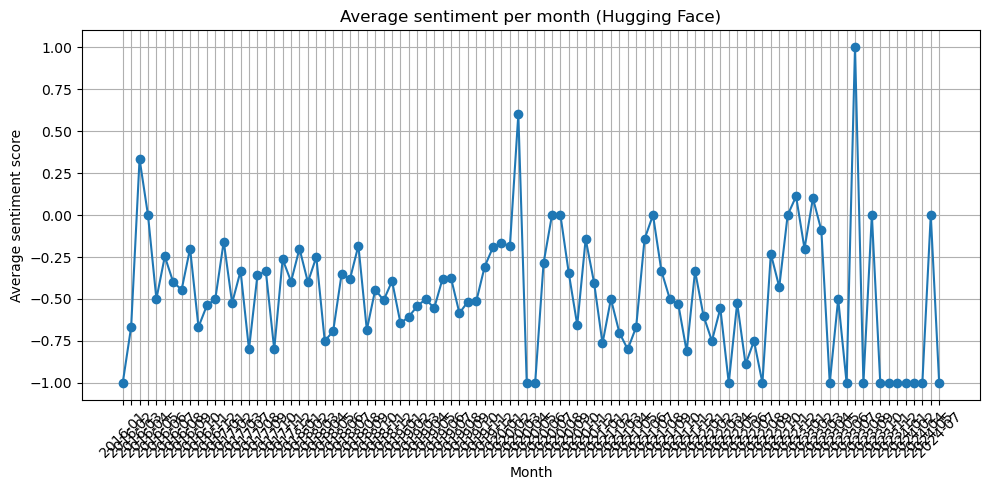

In [18]:
#let's plot the average sentiment per month

monthly_sentiment = articles_df.groupby('month')['sentiment_score'].mean().reset_index()
monthly_sentiment['month'] = monthly_sentiment['month'].astype(str)


plt.figure(figsize=(10, 5))
plt.plot(monthly_sentiment['month'], monthly_sentiment['sentiment_score'], marker='o')
plt.xticks(rotation=45)
plt.title('Average sentiment per month (Hugging Face)')
plt.xlabel('Month')
plt.ylabel('Average sentiment score')
plt.tight_layout()
plt.grid(True)
plt.show()


In [19]:
print(articles_df['year'].unique())


[2021 2023 2022 2024 2019 2020 2018 2017 2016]


   year  sentiment_score
0  2016        -0.394636
1  2017        -0.393939
2  2018        -0.435185
3  2019        -0.513812
4  2020        -0.326165
5  2021        -0.559322
6  2022        -0.522124
7  2023        -0.218750
8  2024        -0.818182


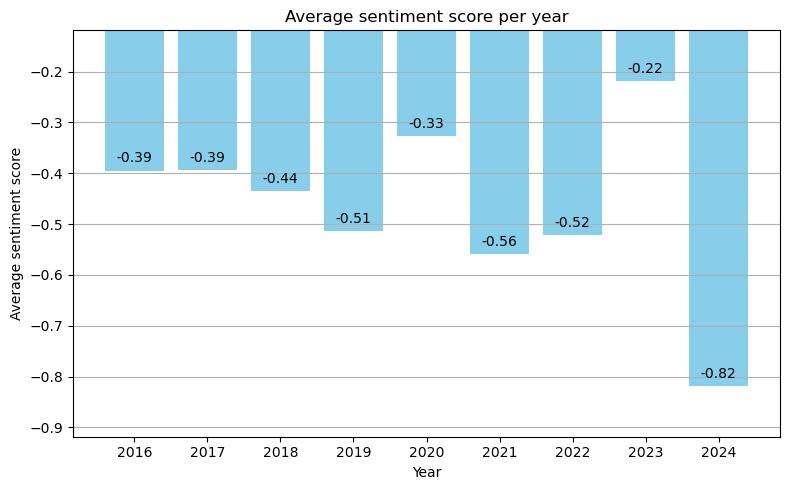

In [20]:
#now we can plot the average sentiment score per year

#we need to make sure 'year' is int and sentiment_score is float to make sure we can use them in the analysis (as numbers)
articles_df['year'] = articles_df['year'].astype(int)
articles_df['sentiment_score'] = articles_df['sentiment_score'].astype(float)

#we group by year and calculate average sentiment per year
yearly_sentiment = articles_df.groupby('year')['sentiment_score'].mean().reset_index()
print(yearly_sentiment)

#finally, let's do the plot 
plt.figure(figsize=(8, 5))
plt.bar(yearly_sentiment['year'].astype(str), yearly_sentiment['sentiment_score'], color='skyblue')

#but we need to add the text of the sentiment_score
for i, v in enumerate(yearly_sentiment['sentiment_score']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.title('Average sentiment score per year')
plt.xlabel('Year')
plt.ylabel('Average sentiment score')
plt.ylim(min(yearly_sentiment['sentiment_score']) - 0.1, max(yearly_sentiment['sentiment_score']) + 0.1) #this adjustq y-axis limits for better spacing
plt.grid(axis='y')
plt.tight_layout()
plt.show()
